In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import sys
import textwrap

sys.path.append("..")

import os
import subprocess
from collections.abc import Iterable
from glob import glob
from os.path import dirname, join
from statistics import mode

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim
from IPython.display import HTML, display
from joblib import Parallel, delayed
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FuncFormatter
from millify import millify
from PIL import Image
from pyproj import Transformer
from skimage.color import label2rgb
# load label
from skimage.measure import find_contours, label
from tqdm import tqdm

from pred2raster import pred2raster
from sample_selection import get_components_stats
from src.io_operations import (fix_relative_paths, get_image_metadata,
                               get_image_pixel_scale, load_args, read_tiff,
                               read_yaml)
from utils import *

import warnings
warnings.filterwarnings('ignore')
import textwrap


In [47]:

def wrap_text(text, width, break_long_words=False):
    return textwrap.fill(text, width=width, break_long_words=break_long_words)

def format_y_ticks(value, _):
    return millify(value, precision=1)


def normalize_img(image):
    
    image = (image - image.min(axis=(0,1))) / (np.quantile(image, 0.99, axis=(0,1)) - image.min())
    
    return image

In [48]:
# Style plots
sns.set_theme(style="whitegrid", font="Times New Roman")

# set figsize
plt.rcParams["figure.figsize"] = (8, 5)

# increase DPI
plt.rcParams["figure.dpi"] = 120

# font family
plt.rcParams['font.family'] = 'times new roman'

DEFAULT_FONT_SIZE = 8
plt.rc('xtick', labelsize=DEFAULT_FONT_SIZE)  
plt.rc('ytick', labelsize=DEFAULT_FONT_SIZE)

# Dict to store colors
dict_colors = {}

# Parallel jobs to load m etrics
N_JOBS = 10

In [49]:
# Repo with training data
INPUT_PATH = "../amazon_input_data"

# repo with model outputs
VERSION_FOLDER = "13_amazon_data"
DATA_PATH = join(dirname(os.getcwd()), VERSION_FOLDER)

# load args from the version
args = load_args(join(DATA_PATH, "args.yaml"))

In [50]:
orthoimage_metadata = get_image_metadata(args.ortho_image)
# convert to default coordinate system
transfomer = Transformer.from_crs(orthoimage_metadata["crs"], "epsg:4326")
x_scale, y_scale = get_image_pixel_scale(args.ortho_image)

In [51]:
def get_iter_stats(iter_folder, labels_file="all_labels_set.tif"):
    
    if "all_labels" in labels_file:
        ITER_STATS_PATH = join(DATA_PATH, iter_folder, "all_labels_stats.parquet")
        
    if "selected_labels" in labels_file:
        ITER_STATS_PATH = join(DATA_PATH, iter_folder, "selected_labels_stats.parquet")
    
    if os.path.exists(ITER_STATS_PATH):
        return pd.read_parquet(ITER_STATS_PATH)
    
    num_iter = int(iter_folder.split("_")[1])
    
    if num_iter != 0:
        label_path = join(DATA_PATH, iter_folder, "new_labels", labels_file)
        
    else:
        label_path = args.train_segmentation_path

    label_img = read_tiff(label_path)

    components = label(label_image = label_img)

    components_stats = get_components_stats(components, label_img)
    components_stats.reset_index(inplace=True)


    components_stats["iter"] = f"iter_{num_iter:03d}"

    components_stats["iter_num"] = num_iter
    
    # save parquet with stats at
    components_stats.to_parquet(ITER_STATS_PATH)
    
    return components_stats

In [52]:
id_tree = pd.read_csv(join(INPUT_PATH,"id_trees.csv"), index_col="label_num")["tree_name"].sort_values()
id_tree.replace("Angico Angico", "Angico", inplace=True)
id_tree.replace("Cedro Cedro", "Cedro", inplace=True)
id_tree

label_num
1       Abiorana Rosa
2              Angico
3     Angico Vermelho
4         Castanheira
5               Cedro
6           Cerejeira
7        Cumaru Ferro
8           Garapeira
9          Guaribeiro
10           Guariuba
11                Ipe
12              Jutai
13       Massaranduba
14            Samauma
15              Tachi
16             Tauari
17             Ucuuba
Name: tree_name, dtype: object

In [53]:
# load data from all iterations
iter_folders = os.listdir(DATA_PATH)

iter_folders = [folder for folder in iter_folders if folder.startswith("iter_")]

iter_folders.sort()

iter_folders.pop();

In [54]:
OUTPUT_PATH_ALL_LABELS_STATS = join(DATA_PATH, "all_labels_stats.parquet")

# carregando dados sobre cada iteracao
all_iter_stats = Parallel(n_jobs=N_JOBS)(
    delayed(get_iter_stats)(iter_folder, "all_labels_set.tif")
    for iter_folder in iter_folders
)

# all_iter_stats corresponde dados gerados para o banco de imagens
all_labels_stats = pd.concat(all_iter_stats)

all_labels_stats["tree_name"] = all_labels_stats["tree_type"].map(id_tree);


In [55]:
OUTPUT_PATH_SELECTED_LABELS_STATS = join(DATA_PATH, "selected_labels_stats.parquet")

selected_iter_stats = Parallel(n_jobs=N_JOBS)(
    delayed(get_iter_stats)(iter_folder, "selected_labels_set.tif")
    for iter_folder in iter_folders
)

# all_iter_stats corresponde dados gerados para o cojunto de treinamento
selected_labels_stats = pd.concat(selected_iter_stats)

selected_labels_stats["tree_name"] = selected_labels_stats["tree_type"].map(id_tree)

In [56]:
metrics_evo = []

for num_iter, iter in enumerate(iter_folders[1:]):
    
    accu = read_yaml(os.path.join(DATA_PATH, iter, "test_metrics.yaml"))
    accu["iter_num"] = num_iter + 1
    
    metrics_evo.append(accu)
    
metrics_evo = pd.DataFrame(metrics_evo)
metrics_evo.columns = metrics_evo.columns.str.replace("test/", "")

In [57]:
TRAIN_GT = read_tiff("../amazon_input_data/segmentation/train_set.tif")
COMP_TRAIN_GT = label(TRAIN_GT)

TEST_GT = read_tiff("../amazon_input_data/segmentation/test_set.tif")
TEST_GT = np.where(TRAIN_GT>0, 0, TEST_GT)
COMP_TEST_GT = label(TEST_GT)

In [58]:
PRED = read_tiff(join(DATA_PATH,iter_folders[-1],"new_labels", "all_labels_set.tif"))
COMP_PRED = label(PRED)

In [59]:
# ORTHOIMAGE = read_tiff(args.ortho_image)
# ORTHOIMAGE = np.moveaxis(ORTHOIMAGE, 0, 2)

# if ORTHOIMAGE.shape[-1] == 25:
#     ORTHOIMAGE = ORTHOIMAGE[...,[5,3,2]].copy()

# if ORTHOIMAGE.max() > 255:
#     ORTHOIMAGE[:] = ORTHOIMAGE/np.quantile(ORTHOIMAGE, 0.99, axis = (0,1))

In [60]:
if all_labels_stats["tree_type"].nunique() == 17:
    dict_colors["tree_name"] = {
        key: color for key, color in zip(id_tree, sns.color_palette("tab20"))
    }

    dict_colors["tree_type"] = {
        key: color for key, color in zip(range(0, 18), sns.color_palette("tab20"))
    }

In [61]:

if all_labels_stats["tree_type"].nunique() == 14:
    
    DEFAULT_COLORS = ('silver', 'blue', 'yellow', 'magenta', 'green', 
                        'indigo', 'darkorange', 'cyan', 'pink', 'yellowgreen', 
                        'red', 'darkgreen', 'gold', 'teal')

    dict_colors["tree_name"] = {
        key: color for key, color in zip(id_tree, DEFAULT_COLORS)
    }

    dict_colors["tree_type"] = {
        key: color for key, color in zip(range(0, 18), DEFAULT_COLORS)
    }

In [62]:
count_tree_type_by_iter = all_labels_stats.groupby(["iter_num", "tree_name"], as_index=False, sort=True)["label"].nunique()
count_tree_type_by_iter.rename(columns={"label": "n_trees"}, inplace=True)

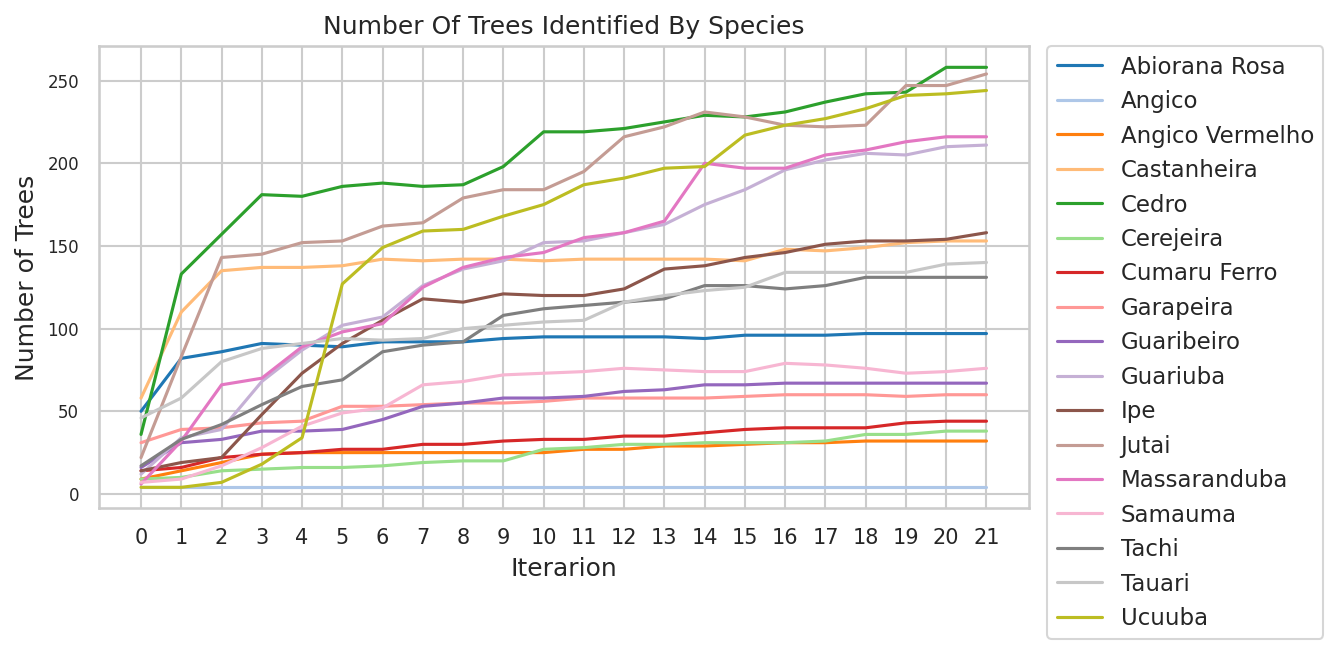

In [63]:
# change size fig
fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.set_dpi(150)

ax = sns.lineplot(
    data=count_tree_type_by_iter,
    x="iter_num",
    y="n_trees",
    hue="tree_name",
    errorbar = None,
    palette=dict_colors["tree_name"],
)

ax.set_title("Number of Trees Identified By Species".title())

ax.set_ylabel("Number of Trees")
ax.set_xlabel("Iterarion")

ax.set_xticks(all_labels_stats['iter_num'].unique())
ax.set_xticklabels(ax.get_xticklabels(), fontdict={"fontsize":10})

format_millify_axis(ax, "y", precision= 2)

set_legend_outside_plot(ax)

plt.show()

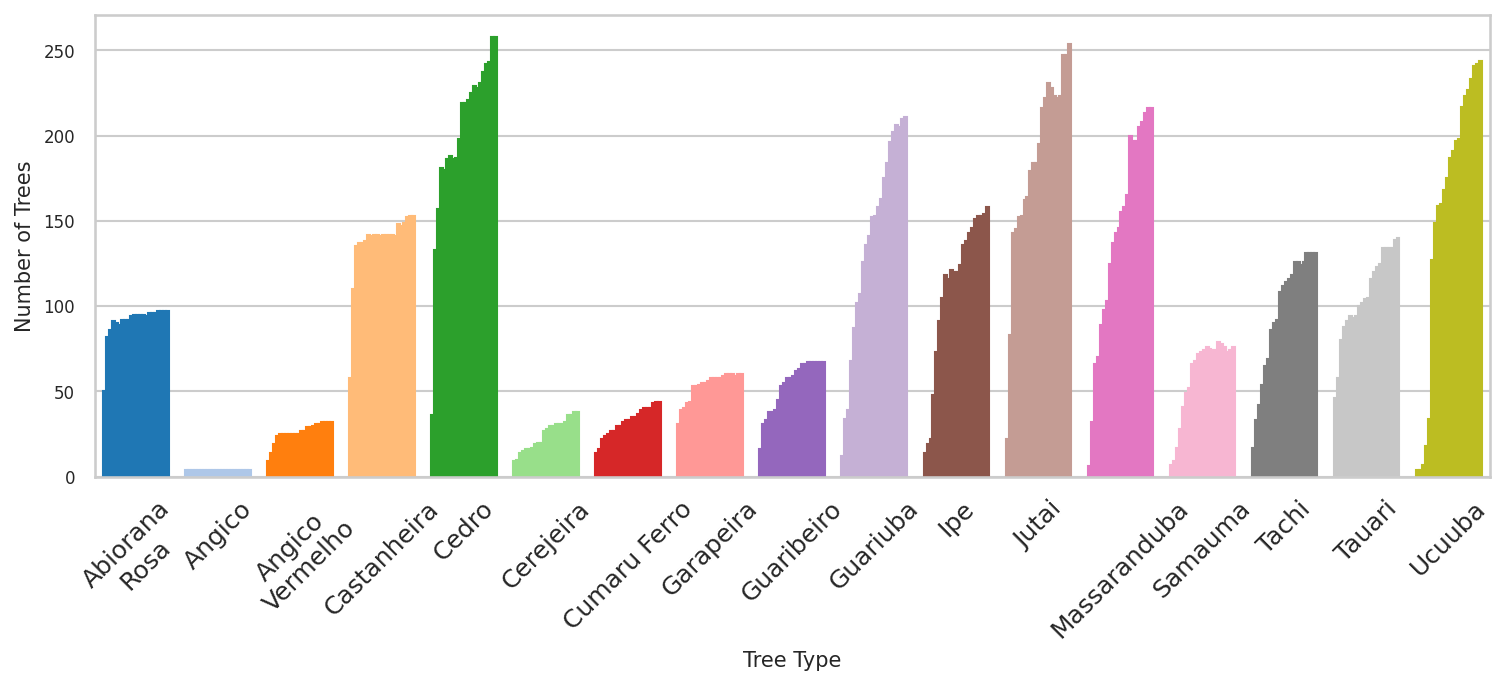

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size and DPI
fig = plt.gcf()
fig.set_size_inches(12, 4)
fig.set_dpi(150)

# Create grouped bar plot
ax = sns.barplot(
    data=count_tree_type_by_iter,
    x="tree_name",  # Group by iteration
    y="n_trees",   # Number of trees as the bar height
    hue="iter_num",  # Different bars for each tree species
)

# Add title and axis labels
# ax.set_title("Number of Trees Identified By Species".title())
ax.set_title("")
ax.set_ylabel("Number of Trees", fontsize=10)
ax.set_xlabel("Tree Type", fontsize=10)

# break x labels too great
# ax.set_xticklabels([textwrap.fill(label.get_text(), 10, break_long_words=False) for label in ax.get_xticklabels()])
ax.set_xticklabels([textwrap.fill(label.get_text(), 12, break_long_words=True, break_on_hyphens=True, fix_sentence_endings=True) for label in ax.get_xticklabels()], fontdict={"fontsize":12}, rotation=45)


# for each group of bars, set a color for tree_name
for i, bar in enumerate(ax.patches):
    tree_name_id = i % count_tree_type_by_iter["tree_name"].nunique()
    color = dict_colors["tree_name"][count_tree_type_by_iter["tree_name"].unique()[tree_name_id]]
    bar.set_color(color)

# Move legend outside of the plot
set_legend_outside_plot(ax)

# remove legend
ax.get_legend().remove()

# Display the plot
plt.show()


,iter_num,tree_name,n_trees
0,0,Abiorana Rosa,50
1,0,Angico,4
2,0,Angico Vermelho,9
3,0,Castanheira,58
4,0,Cedro,36
...,...,...,...
352,20,Massaranduba,216
353,20,Samauma,74
354,20,Tachi,131
355,20,Tauari,139


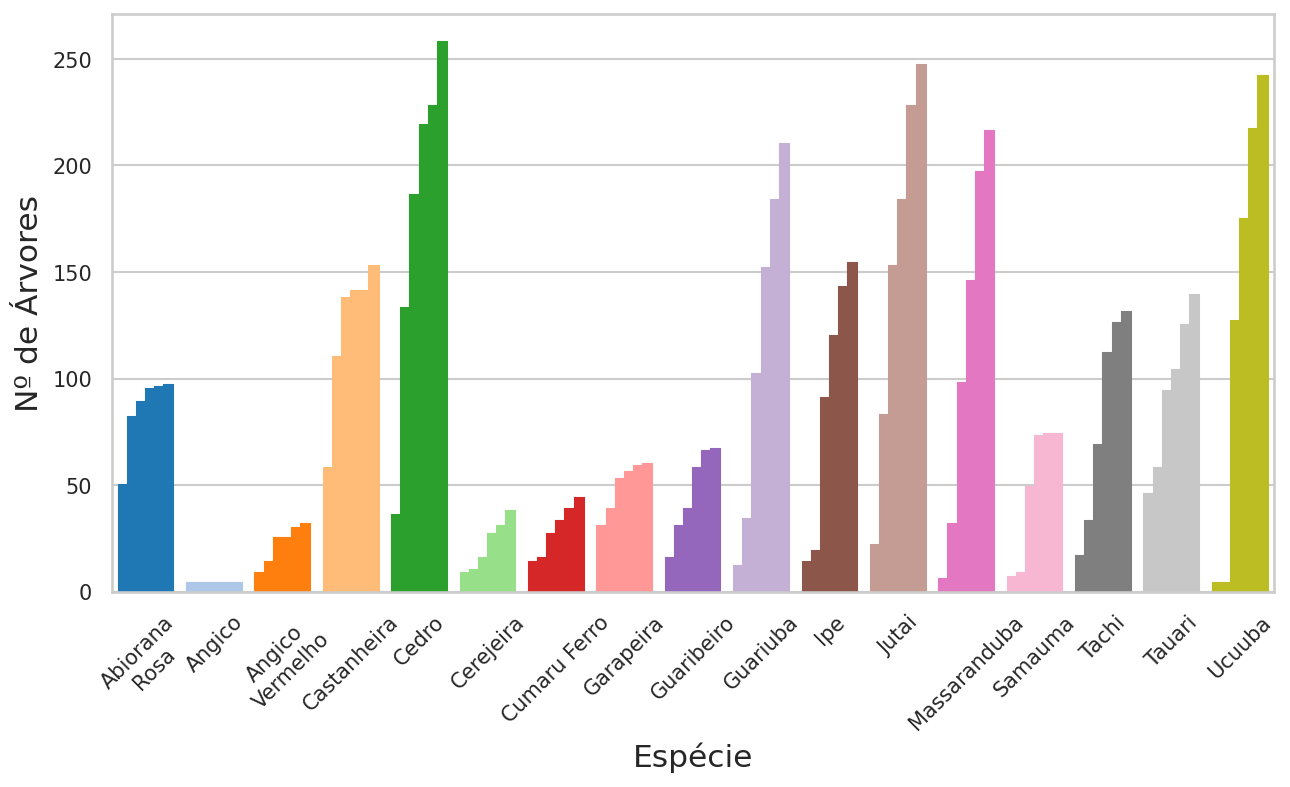

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size and DPI
fig = plt.gcf()
fig.set_size_inches(10, 5)
fig.set_dpi(150)

# Create grouped bar plot
ax = sns.barplot(
    data=count_tree_type_by_iter[count_tree_type_by_iter["iter_num"].isin([0, 1, 5, 10, 15, 20])],
    x="tree_name",  # Group by iteration
    y="n_trees",   # Number of trees as the bar height
    hue="iter_num",  # Different bars for each tree species
)

# Add title and axis labels
# ax.set_title("Number of Trees Identified By Species".title())
ax.set_title("")
ax.set_ylabel("Nº de Árvores", fontsize=15)
ax.set_xlabel("Espécie", fontsize=15)

# set ytickslabels size
ax.set_yticklabels([f"{int(label.get_text()):,}" for label in ax.get_yticklabels()], fontdict={"fontsize":10})

# break x labels too great
# ax.set_xticklabels([textwrap.fill(label.get_text(), 10, break_long_words=False) for label in ax.get_xticklabels()])
ax.set_xticklabels([textwrap.fill(label.get_text(), 12, break_long_words=True, break_on_hyphens=True, fix_sentence_endings=True) for label in ax.get_xticklabels()], fontdict={"fontsize":10}, rotation=45)


# for each group of bars, set a color for tree_name
for i, bar in enumerate(ax.patches):
    tree_name_id = i % count_tree_type_by_iter["tree_name"].nunique()
    color = dict_colors["tree_name"][count_tree_type_by_iter["tree_name"].unique()[tree_name_id]]
    bar.set_color(color)

# Move legend outside of the plot
set_legend_outside_plot(ax)

# remove legend
ax.get_legend().remove()

# save as pdf
plt.savefig("figures/n_trees_by_type_by_iter.pdf", bbox_inches='tight')

# Display the plot
plt.show()


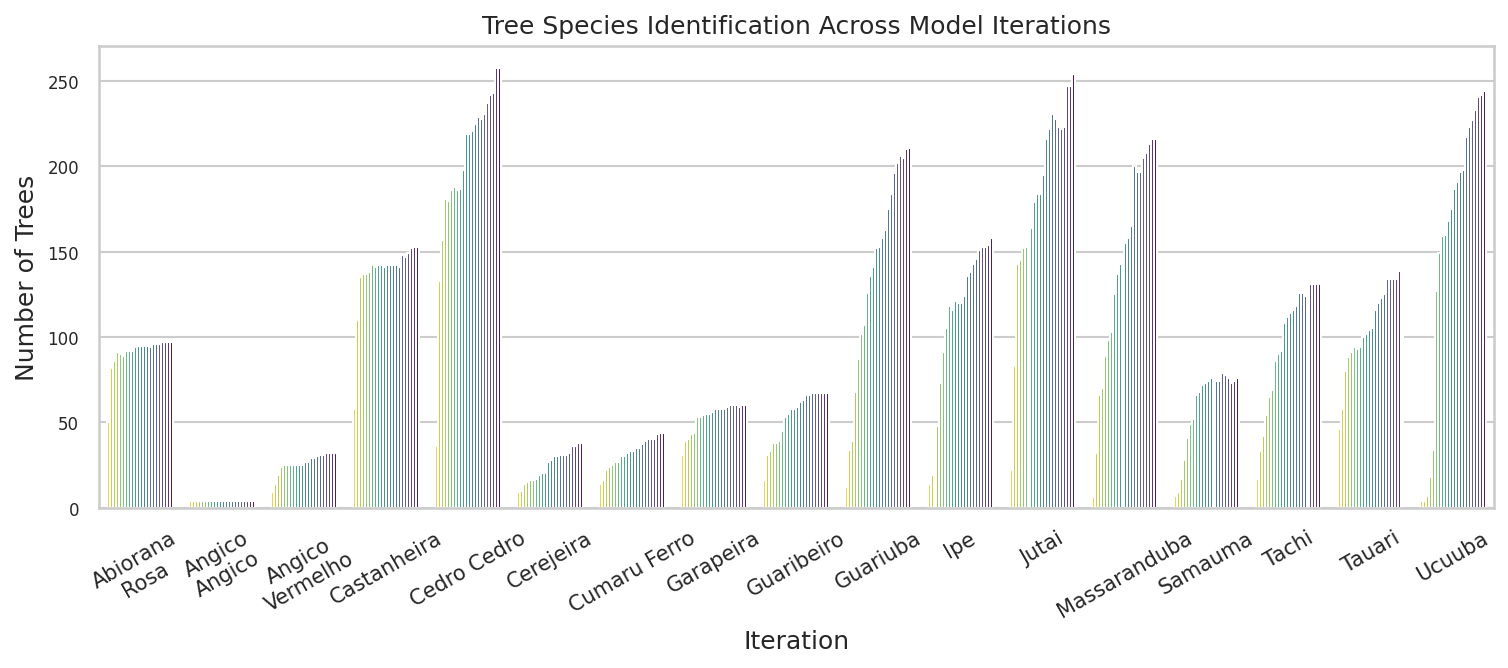

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size and DPI
fig = plt.gcf()
fig.set_size_inches(12, 4)
fig.set_dpi(150)

# Create grouped bar plot
ax = sns.barplot(
    data=count_tree_type_by_iter,
    x="tree_name",  # Group by iteration
    y="n_trees",   # Number of trees as the bar height
    hue="iter_num",  # Different bars for each tree species
    # set viridis color palette
    palette="viridis_r"
)

# Add title and axis labels
ax.set_title("Tree Species Identification Across Model Iterations")
ax.set_ylabel("Number of Trees")
ax.set_xlabel("Iteration")

# break x labels too great
ax.set_xticklabels([textwrap.fill(label.get_text(), 12, break_long_words=True, break_on_hyphens=True, fix_sentence_endings=True) for label in ax.get_xticklabels()], fontdict={"fontsize":10}, rotation=30)

# Move legend outside of the plot
set_legend_outside_plot(ax)

# remove legend
ax.get_legend().remove()

# Display the plot
plt.show()


# Area by Species

In [31]:
# convertendo métricas de área de pxl^2 para metros^2
all_labels_stats["area_m2"] = all_labels_stats["area"] * x_scale * y_scale
all_labels_stats["area_km2"] = (all_labels_stats["area_m2"])/(10**6)

selected_labels_stats["area_m2"] = selected_labels_stats["area"] * x_scale * y_scale
selected_labels_stats["area_km2"] = (selected_labels_stats["area_m2"])/(10**6)

In [32]:
all_labels_stats.head(5)

,label,area,convex_area,bbox_area,extent,solidity,eccentricity,orientation,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,tree_type,iter,iter_num,tree_name,area_m2,area_km2
0,1,143850.0,159183.0,251450.0,0.572082,0.903677,0.867236,-0.753941,288.224039,38277.105666,1,38023,536,38493,8,iter_000,0,Garapeira,230.172910,0.000230
1,2,92741.0,103423.0,133125.0,0.696646,0.896715,0.619697,-0.659316,604.078121,42930.507003,426,42763,801,43118,5,iter_000,0,Cedro Cedro,148.393923,0.000148
2,3,74662.0,81439.0,114464.0,0.652275,0.916784,0.716133,1.339856,670.829793,46092.291032,526,45880,818,46272,13,iter_000,0,Massaranduba,119.465901,0.000119
3,4,102363.0,108279.0,152760.0,0.670090,0.945363,0.657279,0.945054,730.431386,45515.170101,551,45321,931,45723,4,iter_000,0,Castanheira,163.789987,0.000164
4,5,118942.0,121308.0,156348.0,0.760752,0.980496,0.295804,0.006020,933.503825,37721.305973,734,37540,1138,37927,8,iter_000,0,Garapeira,190.317875,0.000190


In [44]:
area_tree_type_by_iter = all_labels_stats.groupby(["iter_num", "tree_name"], as_index=False, sort=True)["area_m2"].sum()


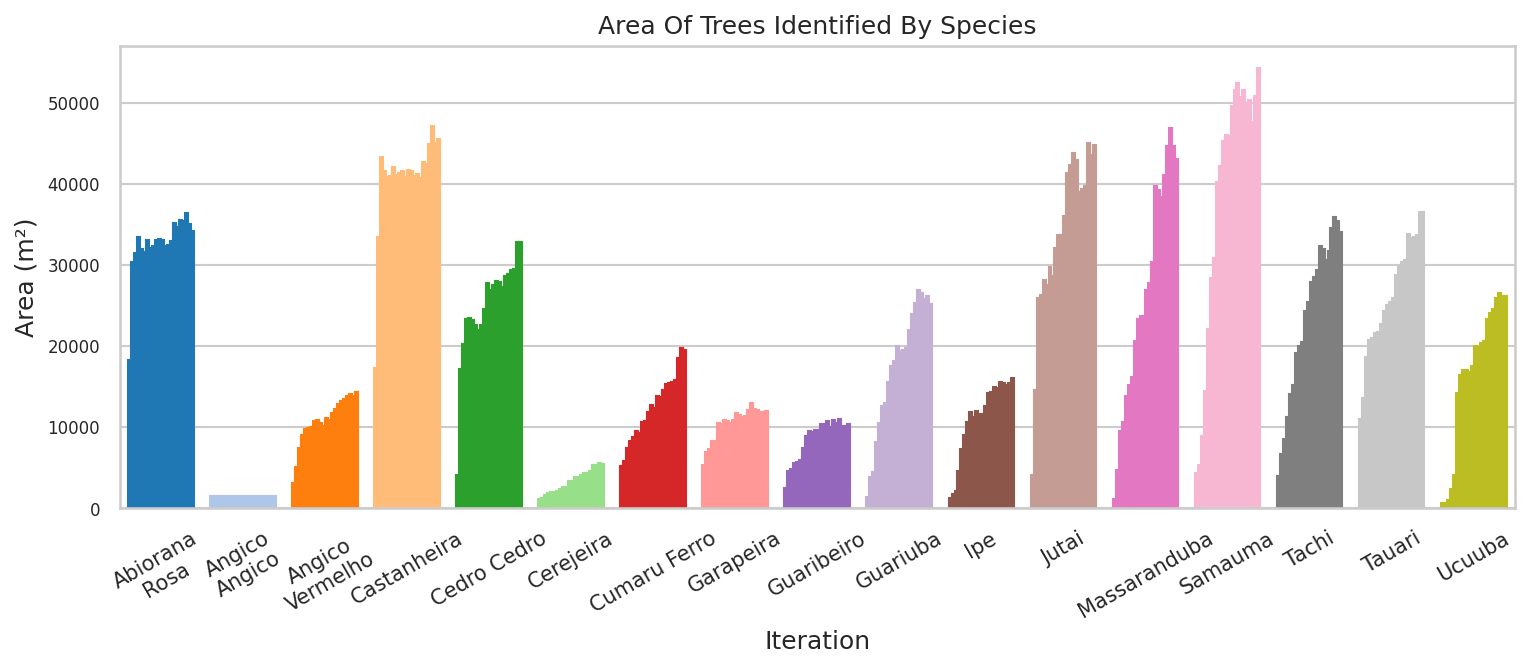

In [47]:


# Set figure size and DPI
fig = plt.gcf()
fig.set_size_inches(12, 4)
fig.set_dpi(150)

# Create grouped bar plot
ax = sns.barplot(
    data=area_tree_type_by_iter,
    x="tree_name",
    y="area_m2",   
    hue="iter_num",
)

# Add title and axis labels
ax.set_title("Area of Trees Identified By Species".title())
ax.set_ylabel("Area (m²)")
ax.set_xlabel("Iteration")

# break x labels too great
# ax.set_xticklabels([textwrap.fill(label.get_text(), 10, break_long_words=False) for label in ax.get_xticklabels()])
ax.set_xticklabels(
    [textwrap.fill(label.get_text(), 12, break_long_words=True, break_on_hyphens=True, fix_sentence_endings=True) for label in ax.get_xticklabels()], 
    fontdict={"fontsize":10}, 
    rotation=30
)


# for each group of bars, set a color for tree_name
for i, bar in enumerate(ax.patches):
    tree_name_id = i % count_tree_type_by_iter["tree_name"].nunique()
    color = dict_colors["tree_name"][count_tree_type_by_iter["tree_name"].unique()[tree_name_id]]
    bar.set_color(color)



# remove legend
ax.get_legend().remove()

# Display the plot
plt.show()
